In [1]:
import sys
sys.path.append("..")
import shap
import xgboost
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import colorsys
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.model_selection import train_test_split

In [2]:
shap.initjs()

In [3]:
notebook_mode = 'Original'
explainer_type = 'XGBoost'
model_type = 'XGBoost'
X,y = shap.datasets.diabetes()
nClusters = 1

In [4]:
# train XGBoost model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
from sklearn.linear_model import LinearRegression
if explainer_type == 'Linear':
    model = LinearRegression().fit(X, y)
else:
    model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

In [5]:
X_instanced = pd.concat((X,pd.DataFrame(columns = ['instance'])),axis = 1)
X_instanced['instance'].loc[X_train.index] = 'train'
X_instanced['instance'].loc[X_test.index] = 'test'
y_instanced = pd.concat((pd.DataFrame(y),pd.DataFrame(columns = ['instance'])),axis = 1)
y_instanced['instance'].loc[X_train.index] = 'train'
y_instanced['instance'].loc[X_test.index] = 'test'

C:\Users\koral\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
if explainer_type == 'Linear':
    explainer = shap.LinearExplainer(model,X)
else:
    explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap_instanced = pd.concat((pd.DataFrame(shap_values),pd.DataFrame(columns = ['instance'])),axis = 1)
shap_instanced['instance'].loc[X_train.index] = 'train'
shap_instanced['instance'].loc[X_test.index] = 'test'

In [7]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:])

In [8]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

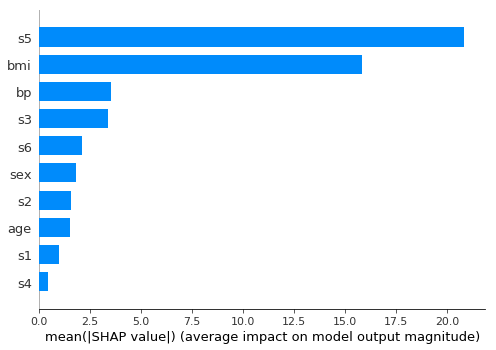

In [9]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X,plot_type = 'bar')

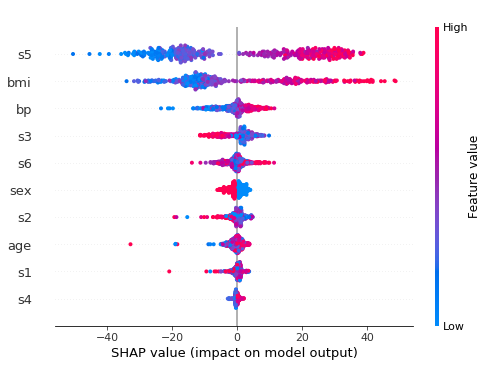

In [10]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

In [11]:
#Gather shapley values and output values in one dataframe
shap_dataframe = pd.DataFrame(data = shap_values,columns = X.columns)
output_dataframe = pd.DataFrame(data = y,columns = ['targets'])
shap_dataframe = pd.concat([shap_dataframe,output_dataframe],axis = 1)

In [12]:
#Make interaction plot for all features
#shap_interaction_values = explainer.shap_interaction_values(X)
#shap.summary_plot(shap_interaction_values, X, max_display = 10)
shap_dataframe.head(20)
#sum(shap_dataframe.iloc[1,:-1])

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,diabetes
0,1.077867,-0.658738,18.187096,-0.093817,-3.956971,2.869789,1.989698,-0.228790,18.461420,-2.871008,151.0
1,-1.198889,2.248281,-12.402168,0.938659,-0.615854,0.733678,-4.540748,-0.425357,-23.238302,-0.353994,75.0
2,-4.863555,-0.831769,5.091377,-5.965988,-2.136698,1.222611,1.596315,-0.537432,15.438137,-0.780819,141.0
3,-4.323865,1.555902,1.272612,-1.990584,-0.176736,-0.978181,3.118552,0.460536,25.332867,3.522316,206.0
4,-2.221312,2.906204,-14.366216,0.543823,0.249101,-0.089670,3.744459,-0.132299,-14.046696,-0.194472,135.0
5,-1.059791,2.558952,-11.367089,0.828144,0.271012,0.230215,-6.573261,-0.310976,-15.052118,0.147261,97.0
6,-0.225278,-4.104653,-11.400326,-0.206087,3.568178,1.040116,3.478182,-0.378223,-20.538324,-1.286635,138.0
7,-1.180561,-4.129454,-6.595448,0.143573,0.800689,-2.535785,-4.421475,-0.052484,-22.892630,-1.825732,63.0
8,-0.132443,-1.221171,17.903292,-10.920288,-0.400874,1.011057,2.711895,-0.523839,-19.246836,-0.320074,110.0
9,-2.505696,0.653724,12.683649,-7.397388,0.235579,1.503210,2.043014,-0.241792,23.359173,2.484350,310.0


In [13]:
X.head(20)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
5,-0.092695,-0.044642,-0.040696,-0.019442,-0.068991,-0.079288,0.041277,-0.076395,-0.041180,-0.096346
6,-0.045472,0.050680,-0.047163,-0.015999,-0.040096,-0.024800,0.000779,-0.039493,-0.062913,-0.038357
7,0.063504,0.050680,-0.001895,0.066630,0.090620,0.108914,0.022869,0.017703,-0.035817,0.003064
8,0.041708,0.050680,0.061696,-0.040099,-0.013953,0.006202,-0.028674,-0.002592,-0.014956,0.011349
9,-0.070900,-0.044642,0.039062,-0.033214,-0.012577,-0.034508,-0.024993,-0.002592,0.067736,-0.013504


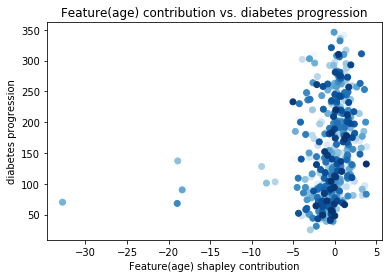

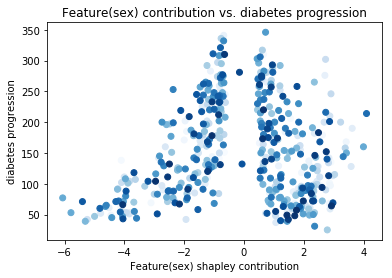

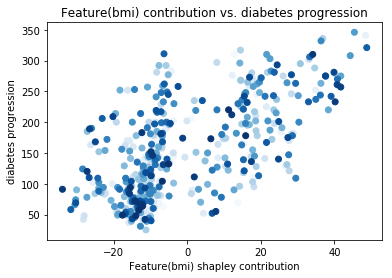

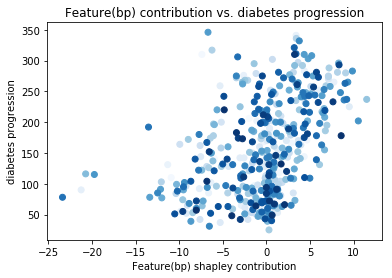

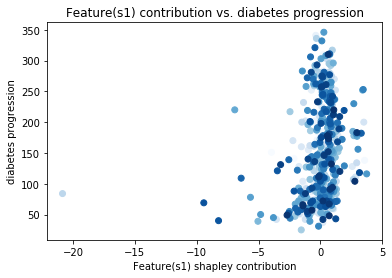

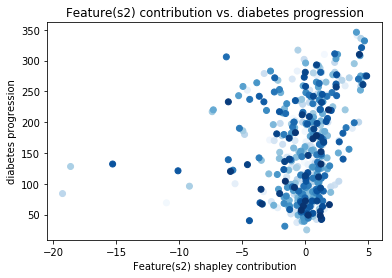

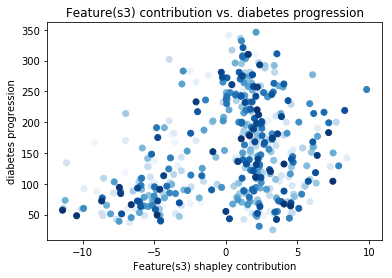

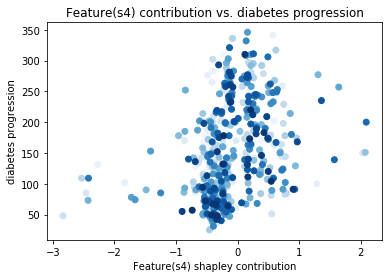

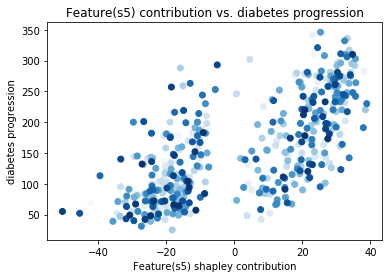

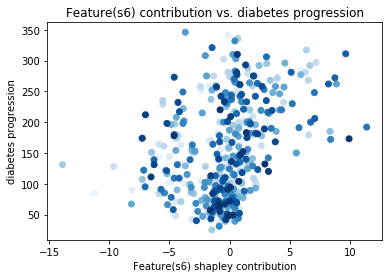

In [14]:
from Framework import plotHelper
plotHelper.plotAllFeatures(shap_dataframe)

In [15]:
#Start clustering
from Framework import cluster
from sklearn.cluster import KMeans
#nClusters = 1
#Train KMeans, because the data is unsupervised(Regression data)
#kmeans = KMeans(n_clusters=3, random_state=0).fit(shap_values)
kmeans = cluster.clusterData(KMeans(n_clusters=nClusters, random_state=0).fit,shap_values)

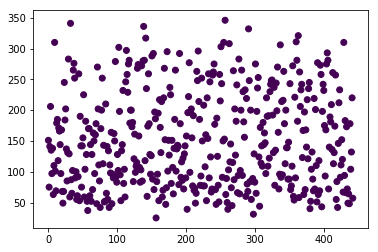

In [16]:
#Get the labels, concat into original data, and sor the labels for into cluster groups
shap_dataframe_labeled = pd.concat([shap_dataframe,pd.DataFrame(kmeans.labels_,columns =[ 'labels'])],axis = 1)
#shap_grouped = shap_dataframe_labeled.sort_values(['labels'])
X_labeled = pd.concat([X,shap_dataframe_labeled['labels']], axis = 1)
plt.scatter(np.linspace(0,442,442),y,c = X_labeled['labels'])

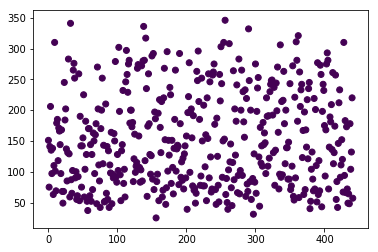

In [17]:
kmeans_original = cluster.clusterData(KMeans(n_clusters=nClusters, random_state=0).fit,X)
plt.scatter(np.arange(len(X)),y,c = kmeans_original.labels_)

In [18]:
#Split the clusters into a dictionary
data_dict = cluster.splitDataLabeled(nClusters,shap_dataframe,shap_dataframe_labeled['labels'])
data_dict_original = cluster.splitDataLabeled(nClusters,X,kmeans_original.labels_)

In [19]:
shap_instanced = pd.concat((pd.DataFrame(shap_values),pd.DataFrame(columns = ['instance'])),axis = 1)
shap_instanced['instance'].loc[X_train.index] = 'train'
shap_instanced['instance'].loc[X_test.index] = 'test'


if notebook_mode == 'Original' or notebook_mode == 'Original-NC':
    original_split = cluster.convertOriginalData(data_dict_original,X_instanced,y_instanced)
    original_split_shapley = cluster.convertOriginalData(data_dict,X_instanced,y_instanced)
elif notebook_mode =='Shapley' or notebook_mode == 'Shapley-NC':
    original_split = cluster.convertOriginalData(data_dict_original,X_instanced,y_instanced)
    original_split_shapley = cluster.convertOriginalData(data_dict,shap_instanced,y_instanced)
else:
    print('Error!')

C:\Users\koral\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


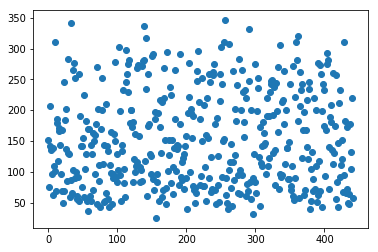

In [20]:
#Scatter the groups again...
#plt.scatter(np.linspace(-1,1,len(original_label_cluster2)),cluster2_predictions)
plt.scatter(np.arange(len(original_split['original_label_cluster0'])),original_split['original_label_cluster0'].iloc[:,0])
#plt.scatter(np.arange(len(original_split['original_label_cluster1'])),original_split['original_label_cluster1'].iloc[:,0])
#plt.scatter(np.arange(len(original_split['original_label_cluster2'])),original_split['original_label_cluster2'].iloc[:,0])

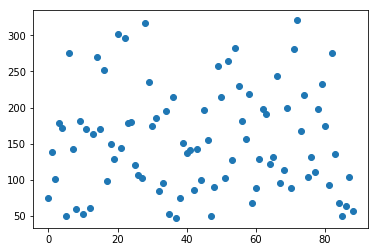

In [21]:
plt.scatter(np.arange(len(original_split_shapley['original_test_label_cluster0'])),original_split_shapley['original_test_label_cluster0'].iloc[:,0])
#plt.scatter(np.arange(len(original_split_shapley['original_test_label_cluster1'])),original_split_shapley['original_test_label_cluster1'].iloc[:,0])
#plt.scatter(np.arange(len(original_split_shapley['original_test_label_cluster2'])),original_split_shapley['original_test_label_cluster2'].iloc[:,0])

In [22]:

#Train split XGBoost models over original data
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse"
}

eval_results = {}
kwargs = {
    'num_boost_round':10000,
    'verbose_eval': 1000,
    'evals_result' : {},
    'early_stopping_rounds' : 200
}
if model_type == 'Linear':
    model_dict,eval_results = cluster.trainMultipleModels(LinearRegression().fit,original_split,'LinearRegressor',params)
else:
    model_dict,eval_results = cluster.trainMultipleModels(xgboost.train,original_split,'XGBoost',params,**kwargs)
#small_model_1 = xgboost.train(params,xgboost.DMatrix(original_split['original_data_cluster0'], label=original_split['original_label_cluster0']),20000,evals = [(xgboost.DMatrix(original_split['original_data_cluster0'], label=original_split['original_label_cluster0']), "train")] ,verbose_eval = 1000)
#small_model_2 = xgboost.train(params,xgboost.DMatrix(original_split['original_data_cluster1'], label=original_split['original_label_cluster1']),20000,evals = [(xgboost.DMatrix(original_split['original_data_cluster1'], label=original_split['original_label_cluster1']), "train")] ,verbose_eval = 1000)
#small_model_3 = xgboost.train(params,xgboost.DMatrix(original_split['original_data_cluster2'], label=original_split['original_label_cluster2']),20000,evals = [(xgboost.DMatrix(original_split['original_data_cluster2'], label=original_split['original_label_cluster2']), "train")] ,verbose_eval = 1000)

[0]	train-rmse:77.018	test-rmse:70.743
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[80]	train-rmse:51.2048	test-rmse:59.0942



In [23]:
#Train split XGBoost models over original data
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse"
}
eval_results_shapley = {}
kwargs = {
    'num_boost_round':10000,
    'verbose_eval': 1000,
    'evals_result' : {},
    'early_stopping_rounds' : 200
}
if model_type == 'Linear':
    model_dict_shapley,eval_results_shapley = cluster.trainMultipleModels(LinearRegression().fit,original_split_shapley,'LinearRegressor',params)
else:
    model_dict_shapley,eval_results_shapley = cluster.trainMultipleModels(xgboost.train,original_split_shapley,'XGBoost',params,**kwargs)
#small_model_shapley1 = xgboost.train(params,xgboost.DMatrix(original_split_shapley['original_data_cluster0'], label=original_split_shapley['original_label_cluster0']),20000,evals = [(xgboost.DMatrix(original_split_shapley['original_data_cluster0'], label=original_split_shapley['original_label_cluster0']), "train")] ,verbose_eval = 1000)
#small_model_shapley2 = xgboost.train(params,xgboost.DMatrix(original_split_shapley['original_data_cluster1'], label=original_split_shapley['original_label_cluster1']),20000,evals = [(xgboost.DMatrix(original_split_shapley['original_data_cluster1'], label=original_split_shapley['original_label_cluster1']), "train")] ,verbose_eval = 1000)
#small_model_shapley3 = xgboost.train(params,xgboost.DMatrix(original_split_shapley['original_data_cluster2'], label=original_split_shapley['original_label_cluster2']),20000,evals = [(xgboost.DMatrix(original_split_shapley['original_data_cluster2'], label=original_split_shapley['original_label_cluster2']), "train")] ,verbose_eval = 1000)

[0]	train-rmse:76.6003	test-rmse:70.2397
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
[1000]	train-rmse:21.4785	test-rmse:32.5042
[2000]	train-rmse:18.104	test-rmse:31.5575
Stopping. Best iteration:
[1858]	train-rmse:18.4744	test-rmse:31.3448



In [24]:
"""plt.plot(np.arange(len(eval_results['eval0']['test']['rmse'])),eval_results['eval0']['test']['rmse'])
plt.plot(np.arange(len(eval_results['eval1']['test']['rmse'])),eval_results['eval1']['test']['rmse'])
plt.plot(np.arange(len(eval_results['eval2']['test']['rmse'])),eval_results['eval2']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval0']['test']['rmse'])),eval_results_shapley['eval0']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval1']['test']['rmse'])),eval_results_shapley['eval1']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval2']['test']['rmse'])),eval_results_shapley['eval2']['test']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('Test-RMSE')
plt.legend(['Model0','Model1','Model2','Model0_Shapley','Model1_Shapley','Model2_Shapley'])"""

"plt.plot(np.arange(len(eval_results['eval0']['test']['rmse'])),eval_results['eval0']['test']['rmse'])\nplt.plot(np.arange(len(eval_results['eval1']['test']['rmse'])),eval_results['eval1']['test']['rmse'])\nplt.plot(np.arange(len(eval_results['eval2']['test']['rmse'])),eval_results['eval2']['test']['rmse'])\nplt.plot(np.arange(len(eval_results_shapley['eval0']['test']['rmse'])),eval_results_shapley['eval0']['test']['rmse'])\nplt.plot(np.arange(len(eval_results_shapley['eval1']['test']['rmse'])),eval_results_shapley['eval1']['test']['rmse'])\nplt.plot(np.arange(len(eval_results_shapley['eval2']['test']['rmse'])),eval_results_shapley['eval2']['test']['rmse'])\nplt.xlabel('Epoch count')\nplt.ylabel('Test-RMSE')\nplt.legend(['Model0','Model1','Model2','Model0_Shapley','Model1_Shapley','Model2_Shapley'])"

In [25]:
"""plt.plot(np.arange(len(eval_results['eval0']['train']['rmse'])),eval_results['eval0']['train']['rmse'])
plt.plot(np.arange(len(eval_results['eval1']['train']['rmse'])),eval_results['eval1']['train']['rmse'])
plt.plot(np.arange(len(eval_results['eval2']['train']['rmse'])),eval_results['eval2']['train']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval0']['train']['rmse'])),eval_results_shapley['eval0']['train']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval1']['train']['rmse'])),eval_results_shapley['eval1']['train']['rmse'])
plt.plot(np.arange(len(eval_results_shapley['eval2']['train']['rmse'])),eval_results_shapley['eval2']['train']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('Train-RMSE')
plt.legend(['Model0','Model1','Model2','Model0_Shapley','Model1_Shapley','Model2_Shapley'])"""

"plt.plot(np.arange(len(eval_results['eval0']['train']['rmse'])),eval_results['eval0']['train']['rmse'])\nplt.plot(np.arange(len(eval_results['eval1']['train']['rmse'])),eval_results['eval1']['train']['rmse'])\nplt.plot(np.arange(len(eval_results['eval2']['train']['rmse'])),eval_results['eval2']['train']['rmse'])\nplt.plot(np.arange(len(eval_results_shapley['eval0']['train']['rmse'])),eval_results_shapley['eval0']['train']['rmse'])\nplt.plot(np.arange(len(eval_results_shapley['eval1']['train']['rmse'])),eval_results_shapley['eval1']['train']['rmse'])\nplt.plot(np.arange(len(eval_results_shapley['eval2']['train']['rmse'])),eval_results_shapley['eval2']['train']['rmse'])\nplt.xlabel('Epoch count')\nplt.ylabel('Train-RMSE')\nplt.legend(['Model0','Model1','Model2','Model0_Shapley','Model1_Shapley','Model2_Shapley'])"

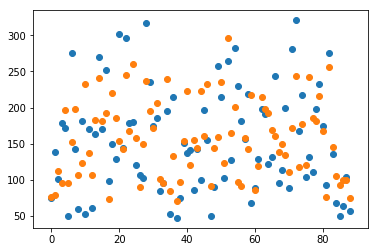

In [26]:
#preds =model.predict(xgboost.DMatrix(original_split['original_data_cluster0']))
plt.scatter(np.arange(len(original_split['original_test_label_cluster0'])),original_split['original_test_label_cluster0'])
plt.scatter(np.arange(len(original_split['original_test_label_cluster0'])),model_dict['model0'].predict(xgboost.DMatrix(original_split['original_test_cluster0'])))

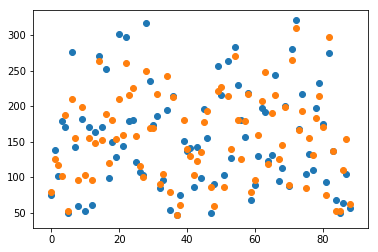

In [27]:
#preds =model.predict(xgboost.DMatrix(original_split['original_data_cluster0']))
plt.scatter(np.arange(len(original_split_shapley['original_test_label_cluster0'])),original_split_shapley['original_test_label_cluster0'])
plt.scatter(np.arange(len(original_split_shapley['original_test_label_cluster0'])),model_dict_shapley['model0'].predict(xgboost.DMatrix(original_split_shapley['original_test_cluster0'])))

In [28]:
#Train overall model
ev_result = {}
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse",
}
if model_type == 'Linear':
    model = LinearRegression().fit(X_train,y_train)
    ev_result['test']['rmse'] = cluster._calculate_accuracy(model.predict,X_test,y_test)
else:
    model = xgboost.train(params,xgboost.DMatrix(X_train, label=y_train),10000,evals = [(xgboost.DMatrix(X_train, label=y_train), "train"),(xgboost.DMatrix(X_test, label=y_test), "test")] ,verbose_eval = 1000,evals_result = ev_result,early_stopping_rounds = 200)
tot_result_big_model = min(ev_result['test']['rmse'])

[0]	train-rmse:77.0041	test-rmse:70.8919
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[74]	train-rmse:51.762	test-rmse:58.7024



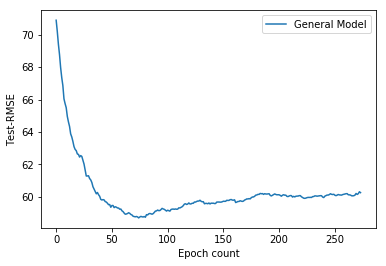

In [29]:
plt.plot(np.arange(len(ev_result['test']['rmse'])),ev_result['test']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('Test-RMSE')
plt.legend(['General Model'])

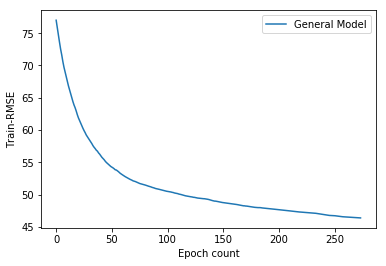

In [30]:
plt.plot(np.arange(len(ev_result['train']['rmse'])),ev_result['train']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('Train-RMSE')
plt.legend(['General Model'])

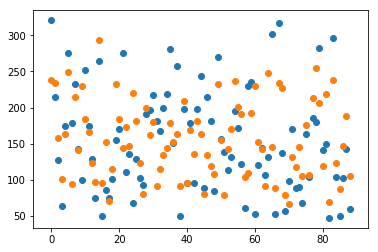

In [31]:
plt.scatter(np.arange(len(X_test)),y_test)
plt.scatter(np.arange(len(X_test)),model.predict(xgboost.DMatrix(X_test)))

In [32]:
#Evaluation of results
from Framework import metrics
sizes = []
rmse_array = []
for i in range(nClusters):
    sizes.append(len(original_split['original_test_label_cluster{0}'.format(i)]))
    rmse_array.append(min(eval_results['eval{0}'.format(i)]['test']['rmse']))
tot_rmse_org = metrics.ensembleRMSE(sizes,rmse_array)

sizes = []
rmse_array = []
for i in range(nClusters):
    sizes.append(len(original_split_shapley['original_test_label_cluster{0}'.format(i)]))
    rmse_array.append(min(eval_results_shapley['eval{0}'.format(i)]['test']['rmse']))
tot_rmse_shap = metrics.ensembleRMSE(sizes,rmse_array)

In [33]:
#Do PCA for dimensionality reduction
nPcaComponents = 2
pca = PCA(n_components=nPcaComponents)
shap_values_pca = pca.fit_transform(shap_values)
print(pca.explained_variance_ratio_.sum())

0.92266536


In [34]:
#Do PCA for dimensionality reduction
nPcaComponents = 2
pca_org = PCA(n_components=nPcaComponents)
org_values_pca = pca_org.fit_transform(X)
print(pca_org.explained_variance_ratio_.sum())

0.5516532410893153


Text(0, 0.5, 'Second principal component')

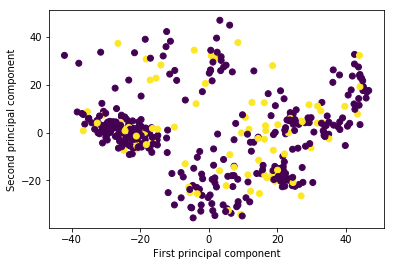

In [35]:
#PCA Clusters are quite seperate,could be used in clustering
label_colors = [ 0 if a == 'train' else 1 for a in X_instanced['instance']]
plt.scatter(shap_values_pca[:,0],shap_values_pca[:,1], c = label_colors)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
#Add to labels to the scatter plot (Colors)
#How do we interpret this ?

In [36]:
kmeans_pca = cluster.clusterData(KMeans(n_clusters=nPcaComponents, random_state=0).fit,shap_values_pca)
kmeans_org_pca = cluster.clusterData(KMeans(n_clusters=nPcaComponents, random_state=0).fit,org_values_pca)

Text(0, 0.5, 'Second principal component')

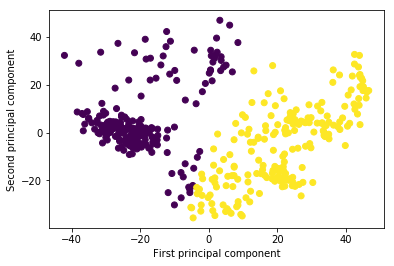

In [37]:
plt.scatter(shap_values_pca[:,0],shap_values_pca[:,1], c = kmeans_pca.labels_)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

In [38]:
data_dict_shap_pca = cluster.splitDataLabeled(2,shap_values_pca,kmeans_pca.labels_)
data_dict_org_pca = cluster.splitDataLabeled(2,org_values_pca,kmeans_org_pca.labels_)

In [39]:
pca_instanced = pd.concat((pd.DataFrame(org_values_pca),pd.DataFrame(columns = ['instance'])),axis = 1)
pca_instanced['instance'].loc[X_train.index] = 'train'
pca_instanced['instance'].loc[X_test.index] = 'test'
shap_pca_instanced = pd.concat((pd.DataFrame(shap_values_pca),pd.DataFrame(columns = ['instance'])),axis = 1)
shap_pca_instanced['instance'].loc[X_train.index] = 'train'
shap_pca_instanced['instance'].loc[X_test.index] = 'test'

C:\Users\koral\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [40]:
original_shap_pca = cluster.convertOriginalData(data_dict_shap_pca,shap_pca_instanced,y_instanced)
original_pca = cluster.convertOriginalData(data_dict_org_pca,pca_instanced,y_instanced)
original_pca

{'original_data_cluster0':             0         1 instance
 0    0.027931 -0.092601    train
 2    0.012945 -0.077764    train
 3    0.002345  0.018182    train
 7    0.098739  0.086945    train
 8    0.028683 -0.041917    train
 11   0.018880 -0.030087    train
 13   0.015147 -0.030969    train
 15   0.140488  0.045190     test
 16   0.007586  0.043395    train
 17   0.108839 -0.007068    train
 23   0.179486 -0.083922    train
 25   0.003924 -0.051083    train
 32   0.124056 -0.139902    train
 38   0.185191  0.020870    train
 39   0.007287 -0.014954    train
 40   0.115508  0.020419    train
 44   0.096800 -0.079761    train
 49   0.061261 -0.068791     test
 51   0.009784 -0.072973    train
 53   0.013467  0.031509    train
 59   0.068994  0.057491     test
 61   0.035773 -0.100596    train
 65   0.082461 -0.051009     test
 66   0.047661 -0.062391    train
 67   0.009971 -0.019372    train
 71   0.084707  0.009747     test
 72   0.080480  0.094680    train
 73   0.048955  0.0259

In [41]:
#Train split XGBoost models over original data
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse"
}
eval_results_org_pca = {}
kwargs = {
    'num_boost_round':10000,
    'verbose_eval': 1000,
    'evals_result' : {},
    'early_stopping_rounds' : 200
}
if model_type == 'Linear':
    model_dic_org_pca,eval_results_org_pca = cluster.trainMultipleModels(LinearRegression().fit,original_pca,'LinearRegressor',params)
else:
    model_dict_org_pca,eval_results_org_pca = cluster.trainMultipleModels(xgboost.train,original_pca,'XGBoost',params,**kwargs)

[0]	train-rmse:82.0609	test-rmse:71.5593
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[41]	train-rmse:65.3506	test-rmse:59.876

[0]	train-rmse:71.2024	test-rmse:69.3574
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[23]	train-rmse:58.3379	test-rmse:63.0663



In [42]:
#Train split XGBoost models over original data
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "reg:squarederror",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "rmse"
}
eval_results_shap_pca = {}
kwargs = {
    'num_boost_round':10000,
    'verbose_eval': 1000,
    'evals_result' : {},
    'early_stopping_rounds' : 200
}
if model_type == 'Linear':
    model_dic_shap_pca,eval_results_shap_pca = cluster.trainMultipleModels(LinearRegression().fit,original_shap_pca,'LinearRegressor',params)
else:
    model_dict_shap_pca,eval_results_shap_pca = cluster.trainMultipleModels(xgboost.train,original_shap_pca,'XGBoost',params,**kwargs)


[0]	train-rmse:69.1456	test-rmse:61.5666
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[140]	train-rmse:32.3174	test-rmse:36.0202

[0]	train-rmse:82.7744	test-rmse:76.3279
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[208]	train-rmse:38.6983	test-rmse:49.979



In [43]:
sizes = []
rmse_array = []
for i in range(nPcaComponents):
    sizes.append(len(original_shap_pca['original_test_label_cluster{0}'.format(i)]))
    rmse_array.append(min(eval_results_shap_pca['eval{0}'.format(i)]['test']['rmse']))
tot_rmse_shap_pca = metrics.ensembleRMSE(sizes,rmse_array)

sizes = []
rmse_array = []
for i in range(2):
    sizes.append(len(original_pca['original_test_label_cluster{0}'.format(i)]))
    rmse_array.append(min(eval_results_org_pca['eval{0}'.format(i)]['test']['rmse']))
tot_rmse_org_pca = metrics.ensembleRMSE(sizes,rmse_array)

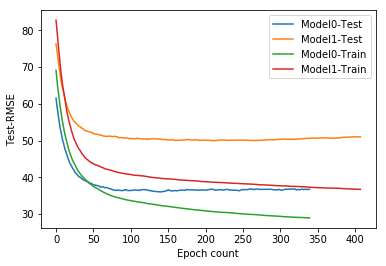

In [44]:
plt.plot(np.arange(len(eval_results_shap_pca['eval0']['test']['rmse'])),eval_results_shap_pca['eval0']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shap_pca['eval1']['test']['rmse'])),eval_results_shap_pca['eval1']['test']['rmse'])
plt.plot(np.arange(len(eval_results_shap_pca['eval0']['train']['rmse'])),eval_results_shap_pca['eval0']['train']['rmse'])
plt.plot(np.arange(len(eval_results_shap_pca['eval1']['train']['rmse'])),eval_results_shap_pca['eval1']['train']['rmse'])
plt.xlabel('Epoch count')
plt.ylabel('Test-RMSE')
plt.legend(['Model0-Test','Model1-Test','Model0-Train','Model1-Train'])

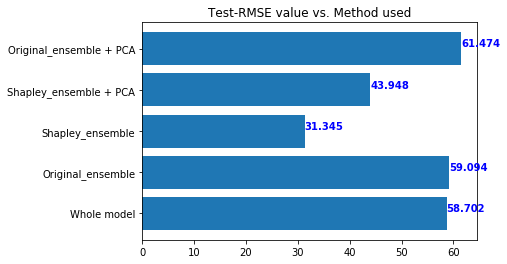

In [45]:
ax = plt.figure()
plt.barh(['Whole model','Original_ensemble','Shapley_ensemble','Shapley_ensemble + PCA','Original_ensemble + PCA'],[tot_result_big_model,tot_rmse_org,tot_rmse_shap,tot_rmse_shap_pca,tot_rmse_org_pca])
plt.title('Test-RMSE value vs. Method used')
for i,v in enumerate([tot_result_big_model,tot_rmse_org,tot_rmse_shap,tot_rmse_shap_pca,tot_rmse_org_pca]):
    plt.text(v , i + .05, '{0:.3f}'.format(v), color='blue', fontweight='bold')

In [46]:
names = ['Whole model','Original_ensemble','Shapley_ensemble','Shapley_ensemble + PCA','Original_ensemble + PCA']
values = [tot_result_big_model,tot_rmse_org,tot_rmse_shap,tot_rmse_shap_pca,tot_rmse_org_pca]
f=open("../Data/test_results.txt", "a+")
f.write('Diabetes,')
[f.write('{0:.3f},'.format(values[v])) for v in range(len(values))]
f.write('{0},'.format(notebook_mode))
f.write('{0},'.format(explainer_type))
f.write('{0}'.format(model_type))
f.write('\n')
f.close()